# Example surface reactor for CO Oxidation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
import pandas as pd
from scipy.optimize import fsolve


In [76]:
# Define reactor conditions
CO_0 = 1.0  # kmol / m^3
O2_0 = 1.0  # kmol / m^3
Ar_0 = 1.0  # kmol / m^3
REACTOR_VOLUME = 1.0  # m^3
volume_flow = 3.32416e-5
REACTOR_TEMPERATURE = 900  # K
REACTOR_PRESSURE = 100000.0  # 1 bar = 100000 Pa
MAX_SIMULATION_TIME = 250.0
CONCENTRATIONS = {
    'CO(4)': 0.1,
    'O2(2)': 0.1,
    'Ar': 0.8,
}

x_CO = CONCENTRATIONS['CO(4)']
x_O2 = CONCENTRATIONS['O2(2)']
x_Ar = CONCENTRATIONS['Ar']


In [77]:
# Read in the mechanism file
model_file = 'chem_annotated.cti'
gas = ct.Solution(model_file, "gas")
surf = ct.Interface(model_file, "surface1", [gas])

MW_Ar = gas.molecular_weights[gas.species_index('Ar')]
MW_CO = gas.molecular_weights[gas.species_index('CO(4)')]
MW_O2 = gas.molecular_weights[gas.species_index('O2(2)')]

# initialize T and P
gas.TPX = REACTOR_TEMPERATURE, REACTOR_PRESSURE, CONCENTRATIONS
surf.TP = REACTOR_TEMPERATURE, REACTOR_PRESSURE


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after removing the cwd from sys.path.


In [78]:
# Catalyst settings (really need to double check these)
catalyst_weight = 4.24e-3
cat_site_per_wt = 5*61.67*1e-6*1e3 # [mol/kg] 1e-6mol/micromole, 1000g/kg
site_density = (
    surf.site_density * 1000
)  # [mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_area = (catalyst_weight * cat_site_per_wt) / site_density  # [m^3]
surf.coverages = "X(1):1.0"


In [79]:
gas_reactor = ct.IdealGasReactor(gas, energy='off')  # off for isothermal
gas_reactor.volume = REACTOR_VOLUME
surface_reactor = ct.ReactorSurface(surf, gas_reactor, A=cat_area)

# set up mass flow controllers
inlet = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

FC_temp = 900
molar_flow = volume_flow * ct.one_atm / (8.3145 * FC_temp)  # [mol/s]
mass_flow = molar_flow * (
    x_CO * MW_CO + x_O2 * MW_O2 + x_Ar * MW_Ar
)  # [kg/s]
mfc = ct.MassFlowController(inlet, gas_reactor, mdot=mass_flow)

outlet_mfc = ct.PressureController(gas_reactor, exhaust, master=mfc, K=0.01)

In [80]:
# initialize reactor network
reactor_network = ct.ReactorNet([gas_reactor])

# set relative and absolute tolerances on the simulation
reactor_network.rtol = 1.0e-11
reactor_network.atol = 1.0e-22


# Now compile a list of all variables for which we will store data
column_names = [gas_reactor.component_name(item) for item in range(gas_reactor.n_vars)]
# column_names = ['pressure'] + column_names
time_history = pd.DataFrame(columns=column_names)

# Run the simulation
t = 0
counter = 1
y_A = []
t_steps = []
while t < MAX_SIMULATION_TIME:
    t = reactor_network.step()

    # store every 10th value
    if counter % 10 == 0:
        state = gas_reactor.get_state()
        #y_A.append(gas_reactor.thermo.X[4])
        t_steps.append(t)

        # Update the dataframe
        time_history.loc[t] = state
    counter += 1


In [81]:
# general plot settings
N = -1

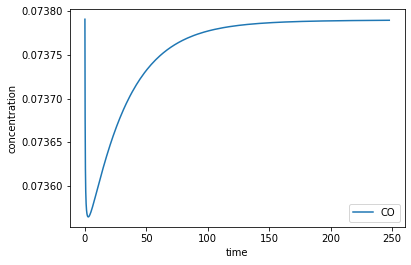

In [82]:
# Plot CO concentration vs time
plt.plot(time_history.index[0:N], time_history['CO(4)'].values[0:N], label='CO')
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.show()

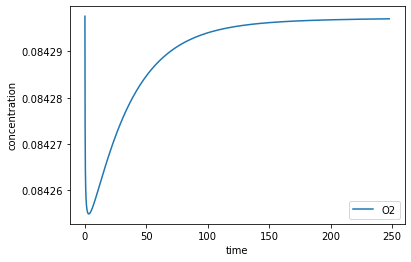

In [83]:
# Plot O2 concentration vs time
plt.plot(time_history.index[0:N], time_history['O2(2)'].values[0:N], label='O2')
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.show()

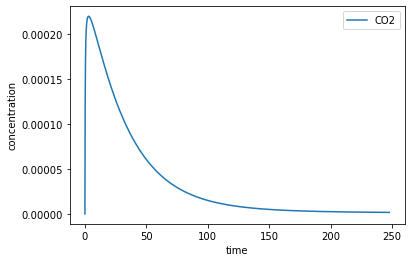

In [84]:
# Plot CO2 concentration vs time
plt.plot(time_history.index[0:N], time_history['CO2(3)'].values[0:N], label='CO2')
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.show()

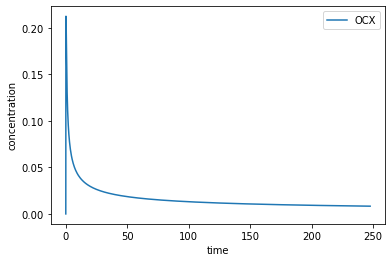

In [86]:
# try to detect poisoning?
# Plot OCX concentration vs time
plt.plot(time_history.index[0:N], time_history['OCX(14)'].values[0:N], label='OCX')
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.show()

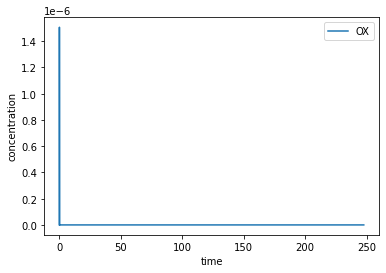

In [87]:
# try to detect poisoning?
# Plot OX concentration vs time
plt.plot(time_history.index[0:N], time_history['OX(8)'].values[0:N], label='OX')
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.show()

In [23]:
#gas.molecular_weights
#gas.species_names


39.948

In [19]:
dir(gas)

['DP',
 'DPX',
 'DPY',
 'HP',
 'HPX',
 'HPY',
 'ID',
 'P',
 'P_sat',
 'SP',
 'SPX',
 'SPY',
 'SV',
 'SVX',
 'SVY',
 'T',
 'TD',
 'TDX',
 'TDY',
 'TP',
 'TPX',
 'TPY',
 'T_sat',
 'UV',
 'UVX',
 'UVY',
 'X',
 'Y',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_check_kinetics_species_index',
 '_check_phase_index',
 '_check_reaction_index',
 '_full_states',
 '_init_cti_xml',
 '_init_parts',
 '_references',
 'activities',
 'activity_coefficients',
 'add_reaction',
 'add_species',
 'atomic_weight',
 'atomic_weights',
 'basis',
 'binary_diff_coeffs',
 'chemical_potentials',
 'concentrations',
 'cp',
 'cp_mass',
 'cp_mole',
 'cr

In [33]:
time_history

,mass,volume,temperature,Ar,Ne,N2,O2(2),CO2(3),CO(4),O2(73),...,CX(15),CO2X2(24),COX2(31),CO2X3(43),O2X2(46),O2X(48),CO3X4(64),C2O2X2(80),C3OX2(107),SX(136)
